# 背景知识
首先从一个text generation的例子开始

In [2]:
import os
# 获取当前工作目录
current_directory = os.getcwd()
print("当前工作目录:", current_directory)

# 设置新的工作目录
new_directory = "/mnt/d/code/llm/llm-course"
os.chdir(new_directory)

# 再次获取当前工作目录，确认是否更改成功
current_directory = os.getcwd()
print("新的工作目录:", current_directory)

当前工作目录: /home/liangxianbing
新的工作目录: /mnt/d/code/llm/llm-course


In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text: I have a dream of being a doctor.


llm生成过程中，是输出logits，logits是一个向量，长度为vocab大小。因此选择logits大的那一个token作为输出，具体过程如下图：
- 将llm当做一个黑箱
- 黑箱的输入是token序列。因此需要将原始句子，通过Tokenizer（一般是BPE算法，Byte-Pair Encoding）转化为token id，这样模型就可以处理了。
- 黑箱的输出是logits，是一个vocab size大小的多分类问题。选择logit最大的那一个类别作为输出token id。然后再decode得到具体单词
- 接下来，将输出的of重新拼接到输入后面组成新的句子[I have a dream of]作为输入，重复这个过程。直到输出<eos>或者到达max_gen_len。（这种方式叫做自回归）
<img src='./imgs/img.png'>  

上面选择最大的logit就是一种Decoding Strategy，就是贪心策略（greedy strategy）

# Decoding Strategies
下面介绍llm中所用到的解码策略：
- Greedy Search（贪心搜索）
- Beam Search（束搜索）
- Top-k sampling（top-k采样）
- Nucleus sampling（核采样）

## 1. Greedy Search
- 每次选择logit最大的那一个token

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def get_log_prob(logits, token_id):
    """
    获取token_id的log probability
    
    :param logits: 
    :param token_id: 
    :return: 
    """
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    
    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    """
    返回
    
    :param input_ids: 输入的token序列
    :param node: 搜索树新结点
    :param length: 生成长度
    :return: 
    """
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = get_log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)
    
    return input_ids

# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
# 用于画出搜索树
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


下面可以画出搜索树

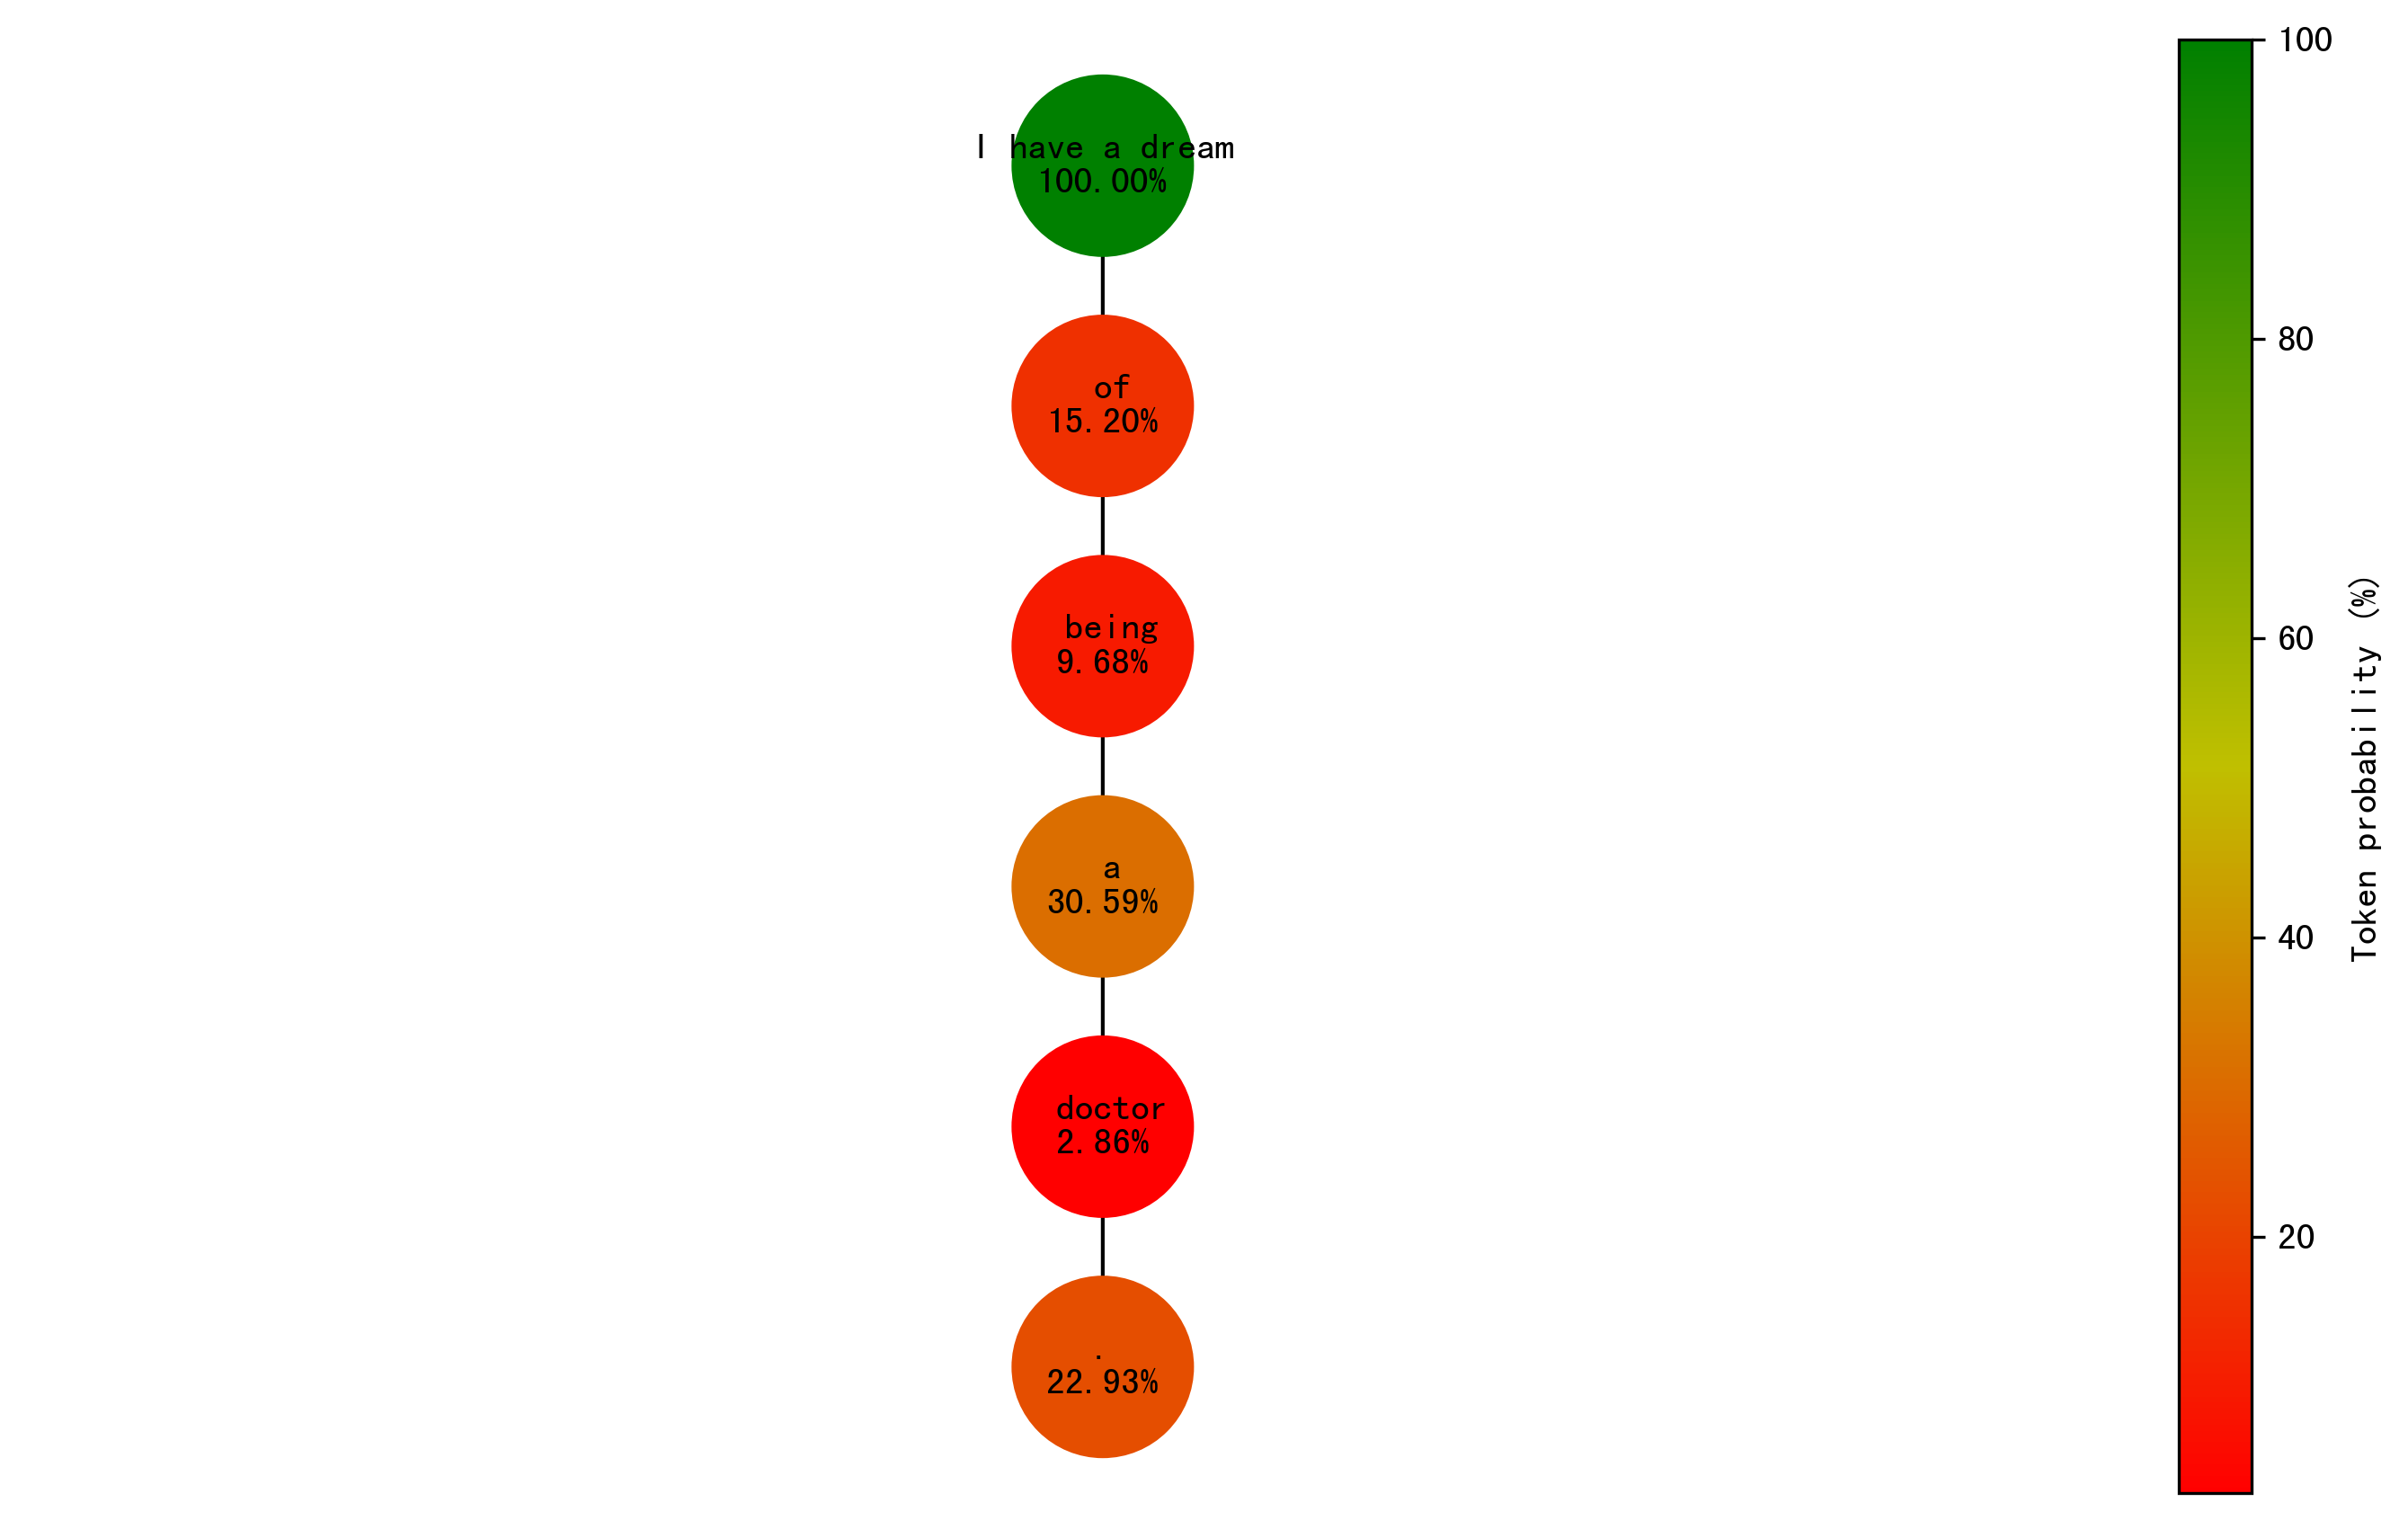

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256) 

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, 
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

## 2. Beam Search
- 束搜索每次考虑最大概率的n个token，n表beam的数目
- 束搜索不是考虑单个token，而是考虑一个序列（这个序列就是beam）最大概率；即这个beam的log probability之和最大

In [44]:
from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    """
    选择bean个logits最大值的indices
    
    :param logits: 
    :param beams: 
    :return: 
    """
    return torch.topk(logits, beams).indices
    
def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):    # 从top k个token id中计算score
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)    # score就是log probability
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

# Parameters
# 超参数，可以设置不同的看看效果 TODO
length = 5
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)

  0%|          | 0/63 [00:00<?, ?it/s]

下面生成句子

In [45]:
def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])
    
    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


下面打印出搜索树

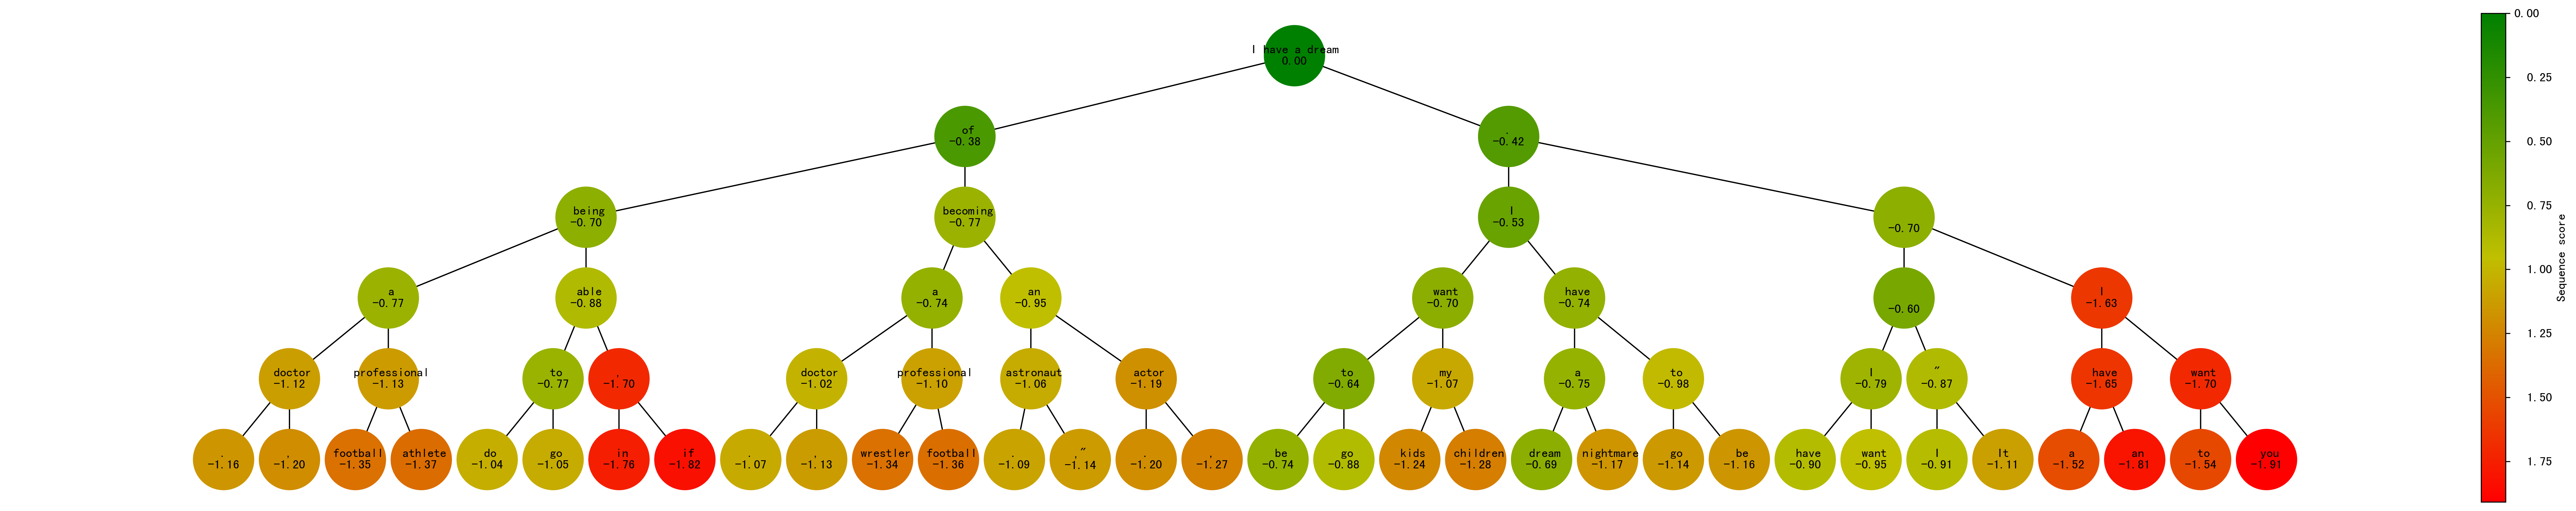

In [46]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

可以看到上面输出的搜索树，每个结点上有两个值，上面是token，下面根结点到当前结点score之和（也就是log prob之和）。beams=2，因此每次选择top 2中的某一个token。因为这了sample='greedy'，因此选择序列得分最大的那一条路径：[I have a dream -> . -> I -> have -> a ->dream]这条路径得到的分数为-0.69，是最有中最大的。

下面一些特殊的结论：
- 当beams设置为1时，就退化为Greedy Search

## 3. Top-k sampling
- 就是从top k中根据概率随机采样
- 这里top_k=20，beams=2。
- 即首先选择top 20的token，改后再概率采样（20首先要归一化）选择其中beams个。然后再利用束搜索选择得分最大的路径

下面计算束搜索与Top k，因为top k中需要按概率采样得到beams个token，因此每次生成的句子都不一样。

In [47]:
def plot_prob_distribution(probabilities, next_tokens, sampling, potential_nb, total_nb=50):
    # Get top k tokens
    top_k_prob, top_k_indices = torch.topk(probabilities, total_nb)
    top_k_tokens = [tokenizer.decode([idx]) for idx in top_k_indices.tolist()]

    # Get next tokens and their probabilities
    next_tokens_list = [tokenizer.decode([idx]) for idx in next_tokens.tolist()]
    next_token_prob = probabilities[next_tokens].tolist()

    # Create figure
    plt.figure(figsize=(0.4*total_nb, 5), dpi=300, facecolor='white')
    plt.rc('axes', axisbelow=True)
    plt.grid(axis='y', linestyle='-', alpha=0.5)
    if potential_nb < total_nb:
        plt.axvline(x=potential_nb-0.5, ls=':', color='grey', label='Sampled tokens')
    plt.bar(top_k_tokens, top_k_prob.tolist(), color='blue')
    plt.bar(next_tokens_list, next_token_prob, color='red', label='Selected tokens')
    plt.xticks(rotation=45, ha='right', va='top')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    if sampling == 'top_k':
        plt.title('Probability distribution of predicted tokens with top-k sampling')
    elif sampling == 'nucleus':
        plt.title('Probability distribution of predicted tokens with nucleus sampling')
    plt.legend()
    plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)
    plt.close()

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'top_k', top_k)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

/tmp/ipykernel_475899/3290751030.py:26: UserWarning: Glyph 160 (\N{NO-BREAK SPACE}) missing from font(s) SimHei.
  plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)


上面生成一系列图片，可以组成动图。因为是根据概率采样，因此概率越大越有可能被选中，所以基本上选择的token集中在左侧。

下面生成句子

In [52]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream about the future. I


下面打印搜索树

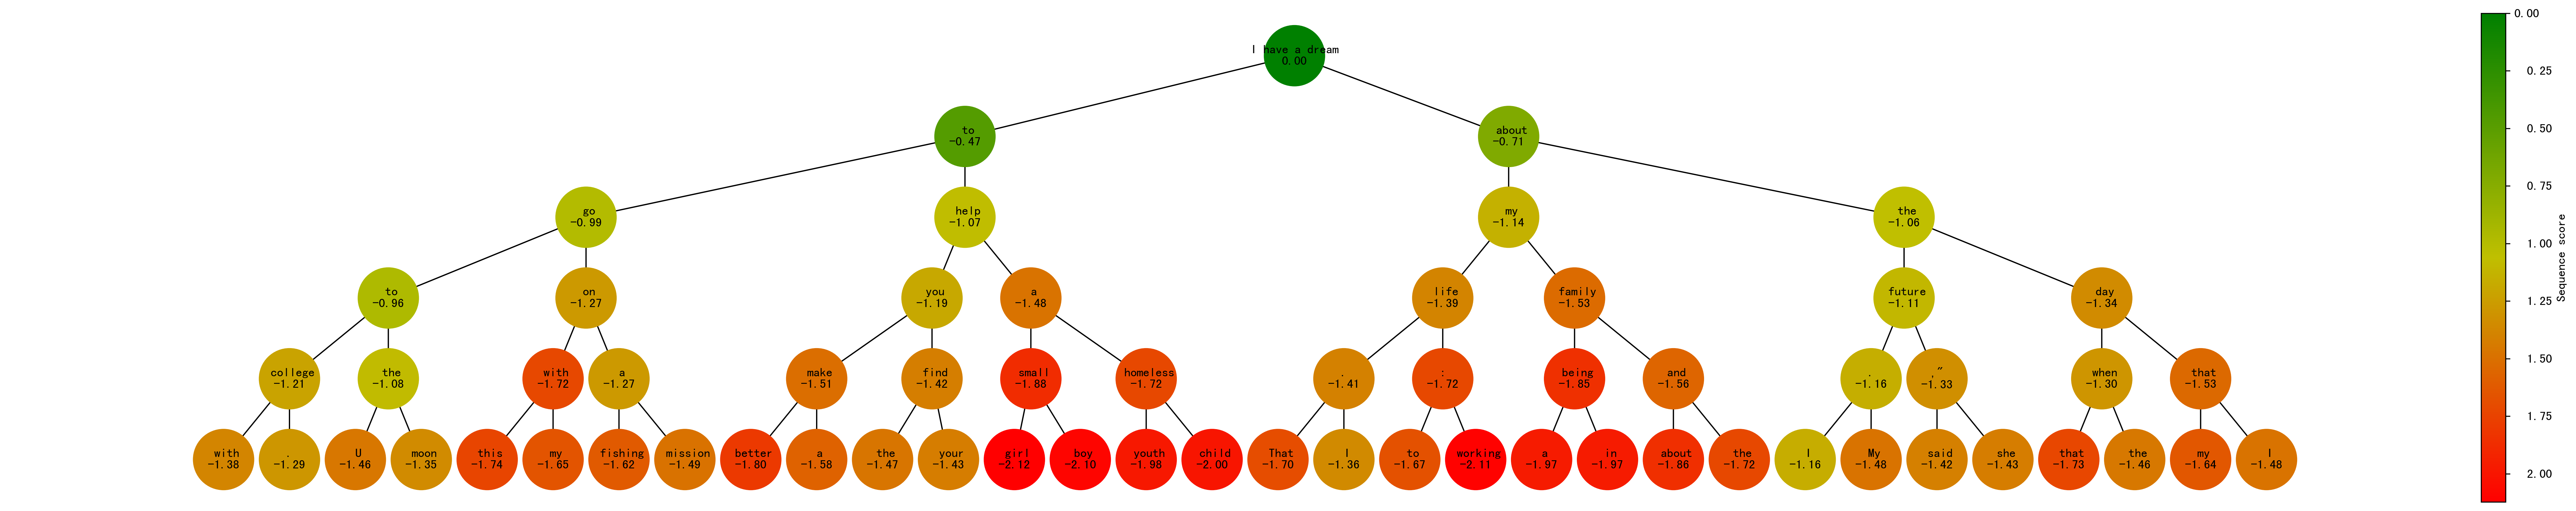

In [49]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

可以看到，最终的socre是这个搜索树中最高的，但是大于原始束搜索中最大值-0.69

下面有一些特殊结论：
- 当k=1时，就相当于greedy，因为此时只有一条路径，它永远被选择
- 当k越大时，随机性越大，越有创造性；当k越小时，就越确定

## 4. Nucleus sampling
- 也叫Top-p sampling。和Top-k sampling选择最大概率的k个不同,Top-p sampling是选择一系列token其概率之和要超过p（首先要将概率从大到小排序，也就是选择最大的n个概率，且这些概率之和超过p）
- 若某次选择了n个token，那么再利用概率采样（n需要重新归一化）得到beams个token（超过beams个阶段为beams个，不够不用特殊处理），然后再利用束搜索选择score最大的路径

下面计算束搜索与Top p，因为top p中需要按概率采样得到beams个token，因此每次生成的句子都不一样。

In [53]:
def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not n index where cumulative_probabilities < p, we use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    # Plot distribution
    if plot:
        total_prob = torch.nn.functional.softmax(logits / temperature, dim=-1)
        plot_prob_distribution(total_prob, next_tokens, 'nucleus', top_p_index_to_keep)

    return next_tokens

# Start generating text
beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

/tmp/ipykernel_475899/3290751030.py:26: UserWarning: Glyph 160 (\N{NO-BREAK SPACE}) missing from font(s) SimHei.
  plt.savefig(f'{sampling}_{time.time()}.png', dpi=300)


上面生成一系列图片，可以组成动图。这些动图中，可以看见每个结点的孩子结点个数差异很大，分布差异也很大。这样生成带来了更多的独特性和多样性

下面生成句子

In [54]:
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

Generated text: I have a dream. I have a dream


下面生成搜索树

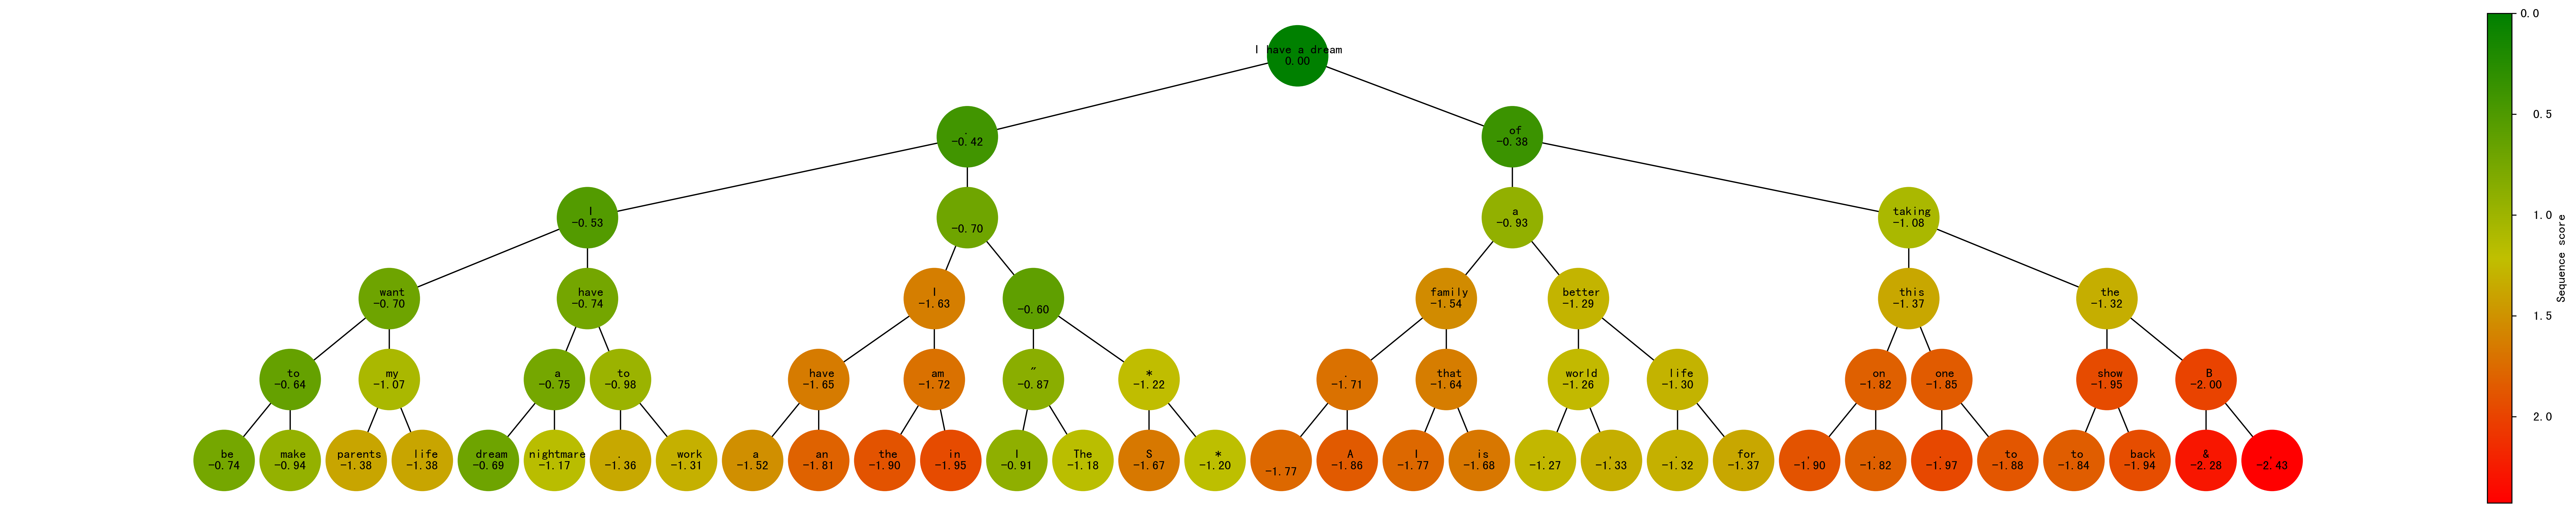

In [55]:
# Plot graph
plot_graph(graph, length, beams, 'sequence')

这里的p设置为0.5，可以看到有些结点有两个孩子，有些结点只有1个孩子。是因为有时候1个孩子的概率就已经大于p=0.5了。这里我们选择的路径是这个搜索树score最大的路径，大于原始束搜索最大score=-0.69

# 总结
- 介绍了4种文本生成的策略。其中重要掌握后3种。
- 注意比较4种策略的搜索树，比较异同。
- temperature超参数用于平滑分布，有些分布会很尖锐，temperature越大，约会越拉近不同token之间的概率差距。也就变得更加随机，更加具有多样性。
- top-k和nucleus（top-p）都是先决定哪些token作为beam参与束搜索，然后再利用束搜索选择最大score的路径；而原始束搜索，相当于直接选择最大beams个概率的token作为beam，然后再利用束搜索选择最大score的路径